In [213]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [277]:
model_name = "gpt2"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model = model.to(device)

In [278]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the entire dictionary to the GPU
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [299]:
with torch.no_grad():
    ## We don't want gradient tracking for this, it consumes memory
    outputs = model(**inputs)
   

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [ ]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990, device='cuda:0')

In [301]:
tokenizer.decode(next_token_id)

' fence'

In [302]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [303]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]], device=inputs["input_ids"].device)],
        dim=1
    ),
}

In [304]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]],
       device='cuda:0') torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0') torch.Size([1, 8])


In [305]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [317]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(100):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]],device=next_inputs["input_ids"].device)],
            dim=1),
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

0.9440791606903076 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' was', ' about', ' to', ' run', ' when', ' he', ' saw', ' the', ' fox', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran']


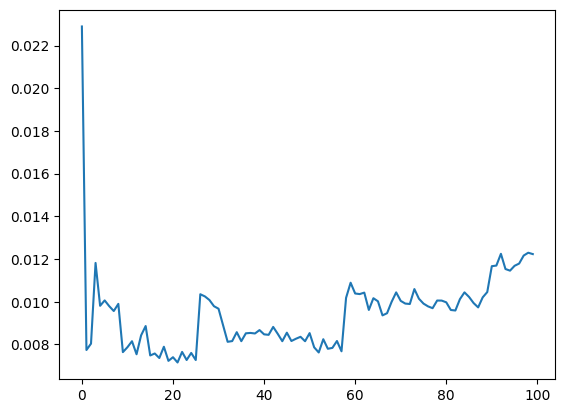

In [318]:
plt.plot(durations_s)
plt.show()

In [319]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    print(next_token_id)
    return next_token_id, outputs.past_key_values

In [320]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(100):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]],device=next_inputs["input_ids"].device)],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

tensor(13990, device='cuda:0')
tensor(290, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
tensor(262, device='cuda:0')
tensor(584, device='cuda:0')
tensor(1735, device='cuda:0')
tensor(286, device='cuda:0')
tensor(262, device='cuda:0')
tensor(13990, device='cuda:0')
tensor(13, device='cuda:0')
tensor(679, device='cuda:0')
tensor(373, device='cuda:0')
tensor(546, device='cuda:0')
tensor(284, device='cuda:0')
tensor(1057, device='cuda:0')
tensor(618, device='cuda:0')
tensor(339, device='cuda:0')
tensor(2497, device='cuda:0')
tensor(262, device='cuda:0')
tensor(21831, device='cuda:0')
tensor(13, device='cuda:0')
tensor(679, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
tensor(262, device='cuda:0')
tensor(584, device='cuda:0')
tensor(1735, device='cuda:0')
tensor(286, device='cuda:0')
tensor(262, device='cuda:0')
tensor(13990, device='cuda:0')
tensor(290, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
t

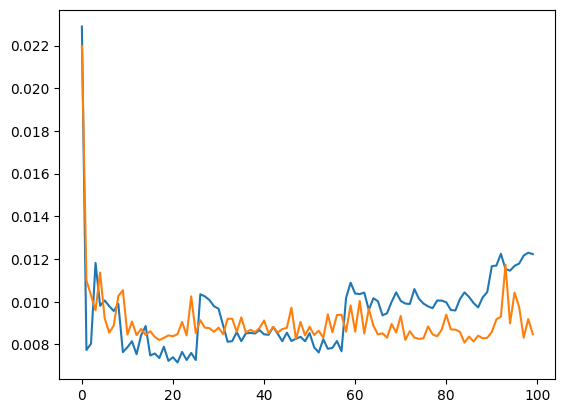

In [321]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()